# Importación

In [ ]:
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Creación barajas

In [ ]:
random.seed(int(time.time()))

In [ ]:
def generar_baraja_mezclada(num_barajas):
    baraja_unica = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K'] * 4
    baraja_total = baraja_unica * num_barajas
    random.shuffle(baraja_total)
    return baraja_total

In [ ]:
def valor_carta(carta):
    if carta in ['J', 'Q', 'K']:
        return 10
    elif carta == 'A':
        return 11
    else:
        return int(carta)

# Cálculo del valor de una mano

In [ ]:
def calcular_total_mano(cartas_jugador):
    total_puntos = sum(valor_carta(c) for c in cartas_jugador)
    cantidad_ases = cartas_jugador.count('A')
    while total_puntos > 21 and cantidad_ases:
        total_puntos -= 10
        cantidad_ases -= 1
    return total_puntos

# Aplicación Q-Learning

In [ ]:
def get_estado(cartas_jugador, carta_crupier):
    # Convierte la situación actual en un estado para Q-Learning
    jugador_total = calcular_total_mano(cartas_jugador)
    return (jugador_total, carta_crupier)

In [ ]:
q_table = {}

In [ ]:
ACCIONES = ['plantarse', 'pedir', 'doblar']

In [ ]:
def inicializar_q_table():
    for jugador_total in range(4, 22):  # 4 a 21
        for carta_crupier in ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']:
            estado = (jugador_total, carta_crupier)
            q_table[estado] = [0.0, 0.0, 0.0]  # [plantarse, pedir, doblar]

In [ ]:
inicializar_q_table()

In [ ]:
def elegir_accion(estado, epsilon=0.1):
    if random.random() < epsilon:
        # Exploración: probar nuevas acciones
        return random.choice(range(len(ACCIONES)))
    else:
        # Explotación: mejor acción conocida
        if estado in q_table:
            return np.argmax(q_table[estado])
        else:
            return random.choice(range(len(ACCIONES)))

In [ ]:
def calcular_recompensa(resultado):
    if resultado == 'ganar':
        return 1
    elif resultado == 'empatar':
        return 0
    elif resultado == 'perder':
        return -1
    else:  # blackjack
        return 1.5

In [ ]:
def simular_mano(baraja, epsilon=0.1):
    # Repartir cartas iniciales
    cartas_jugador = [baraja.pop(), baraja.pop()]
    cartas_crupier = [baraja.pop(), baraja.pop()]

    # Solo vemos una carta del crupier
    carta_crupier_visible = cartas_crupier[0]

    jugador_total = calcular_total_mano(cartas_jugador)

    # Lista para guardar (estado, acción) para Q-Learning
    historial_jugadas = []

    # Verificar blackjack inicial
    if jugador_total == 21:
        crupier_total = calcular_total_mano(cartas_crupier)
        if crupier_total == 21:
            return 'empatar', cartas_jugador, cartas_crupier, historial_jugadas
        else:
            return 'blackjack', cartas_jugador, cartas_crupier, historial_jugadas

    # Turno del jugador
    while jugador_total < 21:
        estado = get_estado(cartas_jugador, carta_crupier_visible)
        accion_idx = elegir_accion(estado, epsilon)
        accion = ACCIONES[accion_idx]

        # Guardar estado y acción
        historial_jugadas.append((estado, accion_idx))

        if accion == 'plantarse':
            break
        elif accion == 'pedir':
            cartas_jugador.append(baraja.pop())
            jugador_total = calcular_total_mano(cartas_jugador)
        elif accion == 'doblar':
            cartas_jugador.append(baraja.pop())
            jugador_total = calcular_total_mano(cartas_jugador)
            break  # Solo una carta más cuando doblas

    # Si el jugador se pasó
    if jugador_total > 21:
        return 'perder', cartas_jugador, cartas_crupier, historial_jugadas

    # Turno del crupier
    crupier_total = calcular_total_mano(cartas_crupier)
    while crupier_total < 17:
        cartas_crupier.append(baraja.pop())
        crupier_total = calcular_total_mano(cartas_crupier)

    # Determinar ganador
    if crupier_total > 21:
        return 'ganar', cartas_jugador, cartas_crupier, historial_jugadas
    elif jugador_total > crupier_total:
        return 'ganar', cartas_jugador, cartas_crupier, historial_jugadas
    elif jugador_total < crupier_total:
        return 'perder', cartas_jugador, cartas_crupier, historial_jugadas
    else:
        return 'empatar', cartas_jugador, cartas_crupier, historial_jugadas

In [ ]:
def actualizar_q_table(estado, accion_idx, recompensa, siguiente_estado, alpha=0.1, gamma=0.9):

    #Nuevo Q(s,a) = Q(s,a) + α[r + γ*max(Q(s',a')) - Q(s,a)]

    if estado not in q_table:
        q_table[estado] = [0.0, 0.0, 0.0]

    if siguiente_estado not in q_table:
        q_table[siguiente_estado] = [0.0, 0.0, 0.0]

    # Valor Q actual
    q_actual = q_table[estado][accion_idx]

    # Mejor valor Q del siguiente estado
    max_q_siguiente = max(q_table[siguiente_estado])

    # Fórmula Q-Learning
    nuevo_q = q_actual + alpha * (recompensa + gamma * max_q_siguiente - q_actual)

    # Actualizar tabla
    q_table[estado][accion_idx] = nuevo_q

# Entrenamiento del agente

In [ ]:
def entrenar_qlearning(num_episodios=10000, epsilon=0.1, alpha=0.1, gamma=0.9):
    print(f"Iniciando entrenamiento con {num_episodios} episodios...")

    victorias = 0

    for episodio in range(num_episodios):
        # Crear nueva baraja para cada episodio
        baraja = generar_baraja_mezclada(num_barajas=4)

        # Simular mano y obtener resultado + historial
        resultado, cartas_jugador, cartas_crupier, historial_jugadas = simular_mano(baraja, epsilon)

        # Calcular recompensa
        recompensa = calcular_recompensa(resultado)

        # Actualizar Q-table usando el historial
        for i, (estado, accion_idx) in enumerate(historial_jugadas):
            if i < len(historial_jugadas) - 1:
                # No es la última jugada - hay un siguiente estado
                siguiente_estado = historial_jugadas[i + 1][0]
                actualizar_q_table(estado, accion_idx, 0, siguiente_estado, alpha, gamma)
            else:
                # Última jugada - usar recompensa final
                # El siguiente estado es "terminal" (fin del juego)
                estado_terminal = (0, 'X')  # Estado dummy (ficticio) para fin de juego
                if estado_terminal not in q_table:
                    q_table[estado_terminal] = [0.0, 0.0, 0.0]
                actualizar_q_table(estado, accion_idx, recompensa, estado_terminal, alpha, gamma)

        # Actualizar estadísticas
        if resultado in ['ganar', 'blackjack']:
            victorias += 1

        # Mostrar progreso cada 1000 episodios
        if (episodio + 1) % 1000 == 0:
            porcentaje_victoria = (victorias / (episodio + 1)) * 100
            print(f"Episodio {episodio + 1}: {porcentaje_victoria:.1f}% victorias")

    print(f"Entrenamiento completado. Victorias finales: {(victorias/num_episodios)*100:.1f}%")

In [ ]:
entrenar_qlearning(num_episodios=10000)

Iniciando entrenamiento con 10000 episodios...
Episodio 1000: 40.5% victorias
Episodio 2000: 39.5% victorias
Episodio 3000: 39.8% victorias
Episodio 4000: 39.8% victorias
Episodio 5000: 39.5% victorias
Episodio 6000: 39.3% victorias
Episodio 7000: 39.3% victorias
Episodio 8000: 39.6% victorias
Episodio 9000: 40.0% victorias
Episodio 10000: 40.0% victorias
Entrenamiento completado. Victorias finales: 40.0%


# Simulación juego


In [ ]:
def recomendar_accion(cartas_jugador, carta_crupier):
    estado = get_estado(cartas_jugador, carta_crupier)
    mejor_accion_idx = np.argmax(q_table[estado])
    return ACCIONES[mejor_accion_idx]

In [ ]:
def mostrar_q_table_con_mejor_accion():
    # Definir los valores posibles para el total del jugador y las cartas del crupier
    totales_jugador = list(range(4, 21))
    cartas_crupier = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']

    # Crear una lista vacía para almacenar las mejores acciones
    mejor_accion_por_estado = []

    # Rellenar la tabla con las mejores acciones
    for total_jugador in totales_jugador:
        fila = []
        for carta_crupier in cartas_crupier:
            estado = (total_jugador, carta_crupier)
            mejor_accion = recomendar_accion([total_jugador], carta_crupier)
            fila.append(mejor_accion)
        mejor_accion_por_estado.append(fila)

    # Convertir la lista de mejores acciones en un DataFrame
    q_df = pd.DataFrame(mejor_accion_por_estado, index=totales_jugador, columns=cartas_crupier)

    return q_df

In [ ]:
q_table

{(4, 'A'): [-0.19, -0.1810607971724295, -0.19],
 (4, '2'): [-0.07436521, -0.06752776402852163, -0.34390000000000004],
 (4, '3'): [-0.1, -0.018610694076437367, -0.1],
 (4, '4'): [-0.19, -0.005228373390695659, 0.1],
 (4, '5'): [-0.010000000000000009, 0.014862176752381998, 0.0],
 (4, '6'): [-0.1, -0.08914762932497704, -0.134909178481],
 (4, '7'): [-0.11629, -0.02049070321048775, -0.1],
 (4, '8'): [0.08494130987090001, -0.03214998236453024, -0.1],
 (4, '9'): [-0.1, -0.07926337538921316, -0.1],
 (4, '10'): [-0.271, -0.27123311289485563, -0.27829000000000004],
 (4, 'J'): [-0.19810000000000003, -0.1774141138712509, -0.271],
 (4, 'Q'): [-0.34390000000000004, -0.22829113883506152, -0.271],
 (4, 'K'): [-0.271, -0.2876915355600631, -0.137339],
 (5, 'A'): [-0.350461, -0.2873483457429362, -0.34390000000000004],
 (5, '2'): [-0.091, -0.05428981608629549, -0.1],
 (5, '3'): [-0.20256628411000005, -0.1329049690202676, -0.19],
 (5, '4'): [-0.18622459000000002, -0.10761395770652005, -0.10900000000000001],

In [ ]:
mostrar_q_table_con_mejor_accion()

,A,2,3,4,5,6,7,8,9,10,J,Q,K
4,pedir,pedir,pedir,doblar,pedir,pedir,pedir,plantarse,pedir,plantarse,pedir,pedir,doblar
5,pedir,pedir,pedir,pedir,pedir,doblar,pedir,pedir,pedir,pedir,pedir,pedir,doblar
6,doblar,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,plantarse,pedir,pedir
7,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,doblar,pedir
8,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir
9,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir
10,pedir,doblar,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir,pedir
11,pedir,pedir,pedir,pedir,pedir,pedir,pedir,doblar,pedir,pedir,pedir,doblar,pedir
12,pedir,pedir,pedir,plantarse,pedir,plantarse,doblar,pedir,pedir,doblar,pedir,pedir,plantarse
13,pedir,pedir,pedir,pedir,plantarse,pedir,pedir,pedir,pedir,plantarse,pedir,plantarse,plantarse


In [ ]:
def simular_partida_unica(baraja, apuesta=10):
    # Repartir cartas iniciales
    cartas_jugador = [baraja.pop(), baraja.pop()]
    cartas_crupier = [baraja.pop(), baraja.pop()]

    carta_crupier_visible = cartas_crupier[0]
    jugador_total = calcular_total_mano(cartas_jugador)
    apuesta_actual = apuesta

    # Verificar blackjack natural del jugador
    if jugador_total == 21:
        crupier_total = calcular_total_mano(cartas_crupier)
        if crupier_total == 21:
            return 0  # Empate
        else:
            return int(apuesta * 1.5)  # Blackjack natural paga 3:2

    # Turno del jugador usando la Q-table entrenada
    doblo = False
    while jugador_total < 21:
        estado = get_estado(cartas_jugador, carta_crupier_visible)
        mejor_accion = recomendar_accion(cartas_jugador, carta_crupier_visible)

        # Controlar que no se pueda doblar con más de 2 cartas
        if mejor_accion == 'doblar' and len(cartas_jugador) > 2:
            mejor_accion = 'pedir'

        if mejor_accion == 'plantarse':
            break
        elif mejor_accion == 'pedir':
            cartas_jugador.append(baraja.pop())
            jugador_total = calcular_total_mano(cartas_jugador)
        elif mejor_accion == 'doblar':
            apuesta_actual *= 2  # Doblar la apuesta
            cartas_jugador.append(baraja.pop())
            jugador_total = calcular_total_mano(cartas_jugador)
            doblo = True
            break  # Solo una carta más cuando doblas

    # Si el jugador se pasó
    if jugador_total > 21:
        return -apuesta_actual

    # Turno del crupier
    crupier_total = calcular_total_mano(cartas_crupier)
    while crupier_total < 17:
        cartas_crupier.append(baraja.pop())
        crupier_total = calcular_total_mano(cartas_crupier)

    # Determinar ganador y calcular ganancia/pérdida
    if crupier_total > 21:
        return apuesta_actual  # Crupier se pasó, jugador gana
    elif jugador_total > crupier_total:
        return apuesta_actual  # Jugador gana
    elif jugador_total < crupier_total:
        return -apuesta_actual  # Jugador pierde
    else:
        return 0  # Empate

In [ ]:
def simular_multiples_partidas(n_juegos=100, apuesta=10, dinero_inicial=100, n_barajas=4):
    dinero_actual = dinero_inicial
    historial_dinero = [dinero_inicial]  # Lista para guardar el dinero después de cada partida

    # Crear baraja inicial
    baraja = generar_baraja_mezclada(n_barajas)

    for partida in range(n_juegos):
        # Si la baraja tiene pocas cartas, crear una nueva
        if len(baraja) < 20:  # Umbral para nueva baraja
            baraja = generar_baraja_mezclada(n_barajas)

        # Si no hay dinero suficiente para apostar, terminar
        if dinero_actual < apuesta:
            break

        # Simular una partida
        resultado_dinero = simular_partida_unica(baraja, apuesta)
        dinero_actual += resultado_dinero
        historial_dinero.append(dinero_actual)

    # Gráfica
    plt.figure(figsize=(10,5))
    plt.plot(range(len(historial_dinero)), historial_dinero, linestyle='-')
    plt.title(f"Evolución del Dinero en {len(historial_dinero)-1} Juegos de Blackjack")
    plt.xlabel("Número de Juegos")
    plt.ylabel("Dinero del Jugador")
    plt.grid(True)
    plt.show()

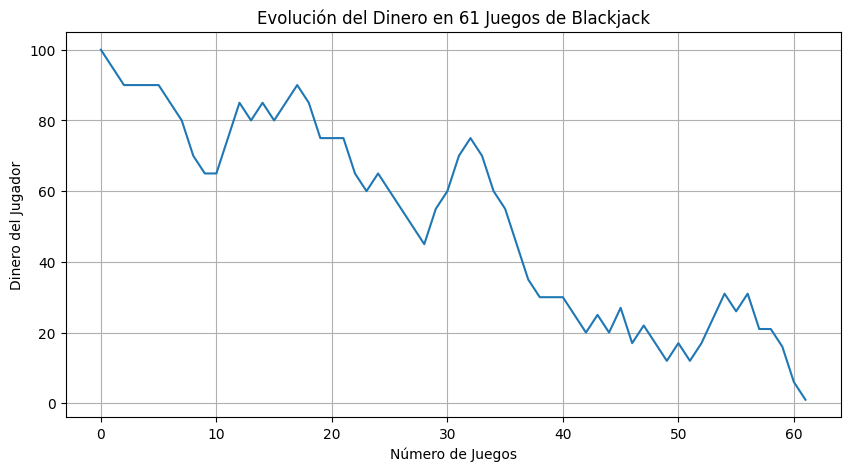

In [ ]:
simular_multiples_partidas(n_juegos=100, apuesta=5, dinero_inicial=100, n_barajas=4)

# Asistente en partidas online

In [ ]:
def jugar():
    print("=== BLACKJACK CON Q-LEARNING ===")

    while True:
        # Cartas iniciales
        cartas_jugador = []
        print("\nIngresa tus 2 cartas iniciales:")
        cartas_jugador.append(input("Carta 1: ").strip().upper())
        cartas_jugador.append(input("Carta 2: ").strip().upper())

        carta_crupier = input("Carta visible del crupier: ").strip().upper()

        total_jugador = calcular_total_mano(cartas_jugador)
        print(f"\nTu mano: {cartas_jugador} (Total: {total_jugador})")
        print(f"Crupier muestra: {carta_crupier}")

        # 21 natural - verificar crupier
        if total_jugador == 21 and len(cartas_jugador) == 2:
            carta_oculta = input("Carta oculta del crupier: ").strip().upper()
            total_crupier = calcular_total_mano([carta_crupier, carta_oculta])

            resultado = "Empate" if total_crupier == 21 else "¡GANASTE!"
            print(f"Tú: 21 | Crupier: {total_crupier} \n{resultado}")

            if input("¿Otra mano? (s/n): ").lower() != 's':
                break
            continue

        # Bucle principal del juego
        while total_jugador < 21:
            # Mostrar recomendación del Q-learning
            recomendacion = recomendar_accion(cartas_jugador, carta_crupier)
            print(f"RECOMENDACIÓN: {recomendacion.upper()}")

            # Opciones disponibles
            opciones = "plantarse/pedir"
            if len(cartas_jugador) == 2:  # Solo doblar con 2 cartas
                opciones += "/doblar"

            accion = input(f"\n¿Qué haces? ({opciones}): ").lower().strip()

            if accion == 'plantarse':
                break
            elif accion == 'pedir':
                nueva_carta = input("¿Qué carta sacaste?: ").strip().upper()
                cartas_jugador.append(nueva_carta)
                total_jugador = calcular_total_mano(cartas_jugador)
                print(f"Tu mano: {cartas_jugador} (Total: {total_jugador})")
            elif accion == 'doblar' and len(cartas_jugador) == 2:
                nueva_carta = input("¿Qué carta sacaste al doblar?: ").strip().upper()
                cartas_jugador.append(nueva_carta)
                total_jugador = calcular_total_mano(cartas_jugador)
                print(f"Doblaste. Mano final: {cartas_jugador} (Total: {total_jugador})")
                break
            else:
                print("Acción no válida. Intenta de nuevo.")

        # Si te pasaste
        if total_jugador > 21:
            print("Te pasaste - Perdiste")
        else:
            # Turno del crupier
            print("\n--- Turno del crupier ---")
            cartas_crupier = [carta_crupier]
            total_crupier = calcular_total_mano(cartas_crupier)

            while total_crupier < 17:
                nueva_carta = input("¿Qué carta sacó el crupier?: ").strip().upper()
                cartas_crupier.append(nueva_carta)
                total_crupier = calcular_total_mano(cartas_crupier)
                print(f"Crupier: {cartas_crupier} (Total: {total_crupier})")

            # Resultado final
            print(f"\nRESULTADO:")
            print(f"Tú: {total_jugador} | Crupier: {total_crupier}")

            if total_crupier > 21:
                print("¡GANASTE! - El crupier se pasó")
            elif total_jugador > total_crupier:
                print("¡GANASTE!")
            elif total_jugador < total_crupier:
                print("Perdiste")
            else:
                print("Empate")

        # Nueva partida
        if input("\n¿Otra mano? (s/n): ").lower() != 's':
            break

In [ ]:
jugar()

=== BLACKJACK CON Q-LEARNING ===

Ingresa tus 2 cartas iniciales:
